In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv("data.csv")
data = df.drop(columns=["country"]).astype(float)

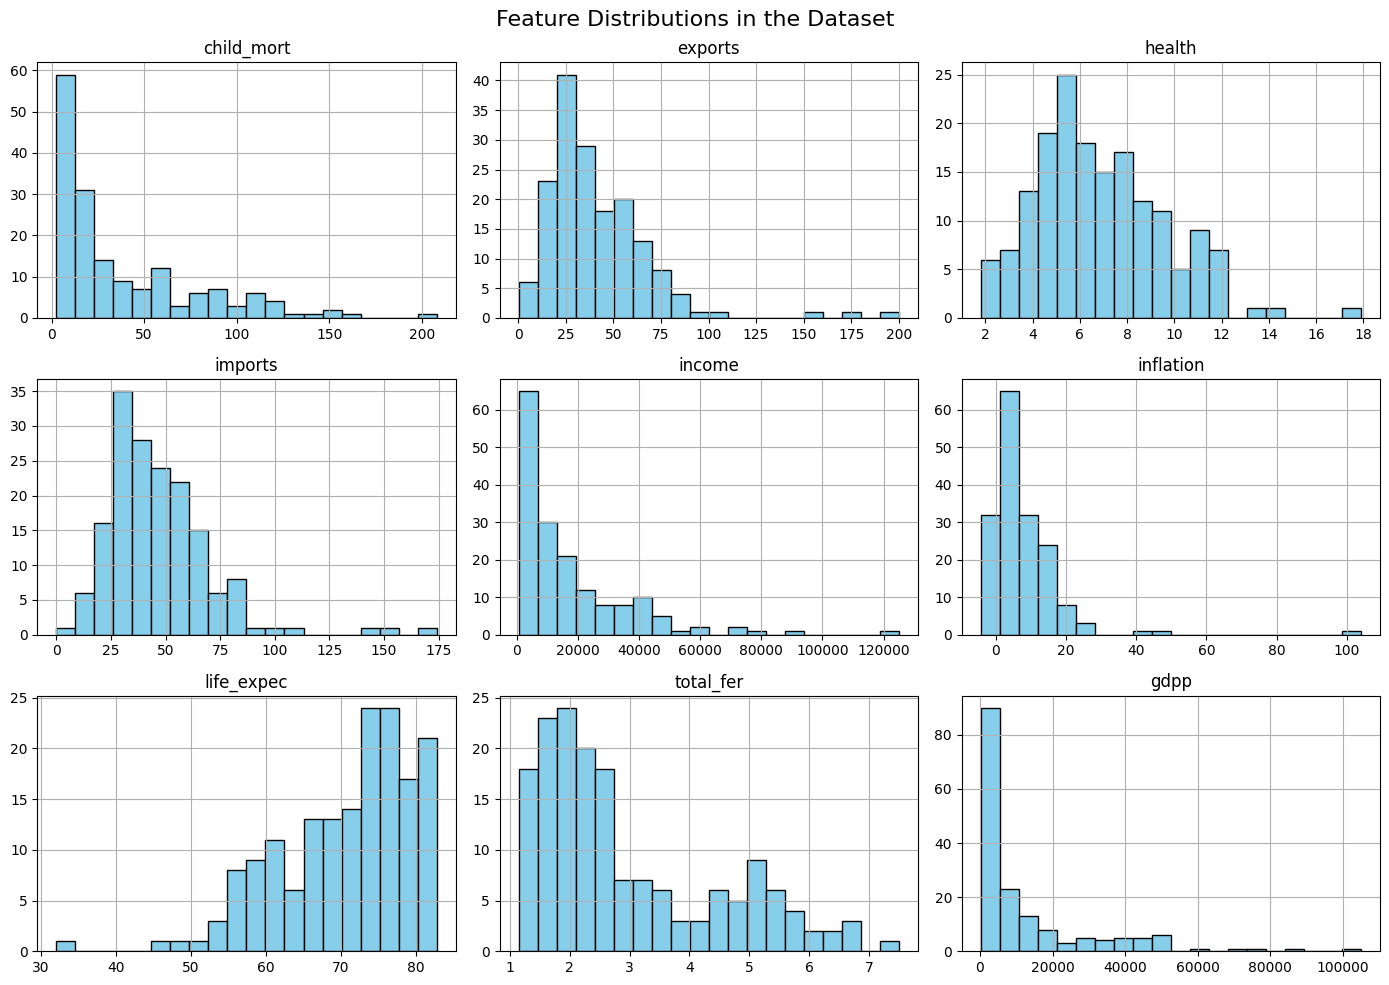

In [97]:
data.hist(figsize=(14, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions in the Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [98]:
#Heavy skew in income, gdpp, inflation


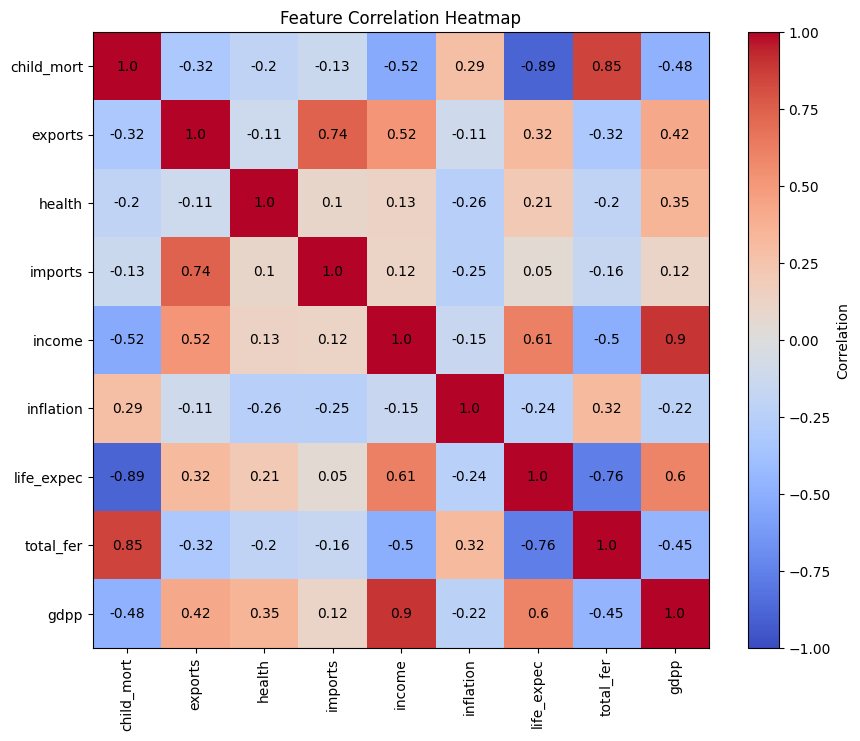

In [99]:
corr = data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature Correlation Heatmap")
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, round(corr.iloc[i, j], 2), ha="center", va="center")
plt.show()

In [100]:
def train_test_split(X, y, test_size=0.25, random_state=42):
    rng = np.random.RandomState(random_state)
    idx = np.arange(len(X))
    rng.shuffle(idx)
    split = int(len(X) * (1 - test_size))
    return X[idx[:split]], X[idx[split:]], y[idx[:split]], y[idx[split:]]

class StandardScaler:
    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1
    def transform(self, X):
        return (X - self.mean_) / self.std_
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, Xs):
        return Xs * self.std_ + self.mean_

In [101]:
def euclidean_distances(X_train, x):
    return np.sqrt(np.sum((X_train - x) ** 2, axis=1))

def knn_regression(X_train, y_train, X_test, k=3):
    preds = []
    for x in X_test:
        dists = euclidean_distances(X_train, x)
        idx = np.argsort(dists)[:k]
        preds.append(np.mean(y_train[idx]))
    return np.array(preds)

In [102]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

# Finding best features

In [103]:
from itertools import combinations

In [104]:
all_features = [
    "child_mort", "exports", "health", "imports",
    "income", "inflation", "total_fer", "gdpp"
]

target = "life_expec"
y = data[target].values

random_states = [0, 1, 7, 13, 42, 99, 123, 456, 789, 999]  

best_mean_rmse = float("inf")
best_std_rmse = float("inf")
best_features = None


for r in range(1, len(all_features) + 1):
    for subset in combinations(all_features, r):
        subset = list(subset)
        X_subset = data[subset].values
        
        rmses = []
        for rs in random_states:
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y, random_state=rs)
            
            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s = scaler.transform(X_test)
            
            preds = knn_regression(X_train_s, y_train, X_test_s, k=3)
            rmses.append(rmse(y_test, preds))
        
        mean_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        
       
        if (mean_rmse < best_mean_rmse) or (mean_rmse == best_mean_rmse and std_rmse < best_std_rmse):
            best_mean_rmse = mean_rmse
            best_std_rmse = std_rmse
            best_features = subset

In [105]:
print("BEST + STABLE FEATURE SUBSET FOUND")
print("Features :", best_features)

BEST + STABLE FEATURE SUBSET FOUND
Features : ['child_mort', 'income', 'inflation']


#####  - 'imports' consistently increased RMSE (weak signal + high variance).
##### - 'income' and 'gdpp' are highly correlated (0.90); keeping 'gdpp' alone is sufficient.
##### - 'total_fer' is redundant with 'child_mort' (corr 0.85) and adds distance distortion in KNN.
##### - Final features retain strong predictors (child_mort, gdpp) while adding contextual signals (exports, health, inflation).
##### - Result: Lower, more stable RMSE without overfitting to a single split.

In [106]:
# first finding lowest came around 3.8 then for a stable one 

In [107]:
X_final = data[best_features].values
X_train, X_test, y_train, y_test = train_test_split(X_final, y, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

final_preds = knn_regression(X_train_s, y_train, X_test_s, k=3)

print("FINAL MODEL PERFORMANCE ")
print("Features :", best_features)
print("k = 3")
print("RMSE :", rmse(y_test, final_preds))
print("MAE  :", mae(y_test, final_preds))
print("R²   :", r2(y_test, final_preds))

FINAL MODEL PERFORMANCE 
Features : ['child_mort', 'income', 'inflation']
k = 3
RMSE : 4.205036033416128
MAE  : 3.147619047619049
R²   : 0.7594861409349535


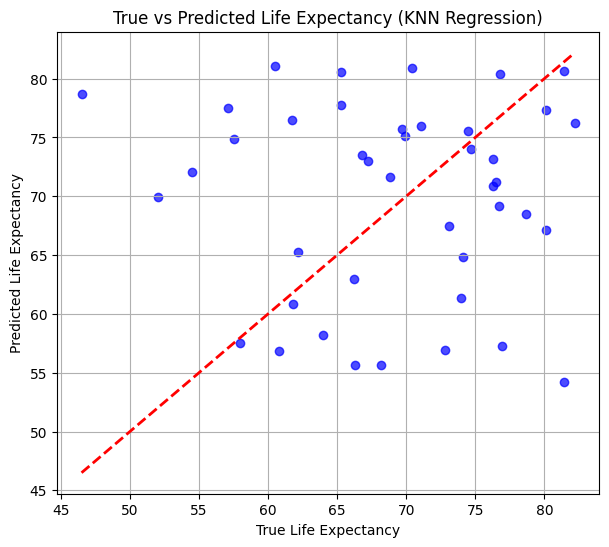

In [108]:
plt.figure(figsize=(7,6))
plt.scatter(y_test, preds, alpha=0.7, color='blue')
min_v = min(y_test.min(), preds.min())
max_v = max(y_test.max(), preds.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', lw=2)
plt.xlabel("True Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("True vs Predicted Life Expectancy (KNN Regression)")
plt.grid(True)
plt.show()

In [109]:
#Minor deviations in mid-range

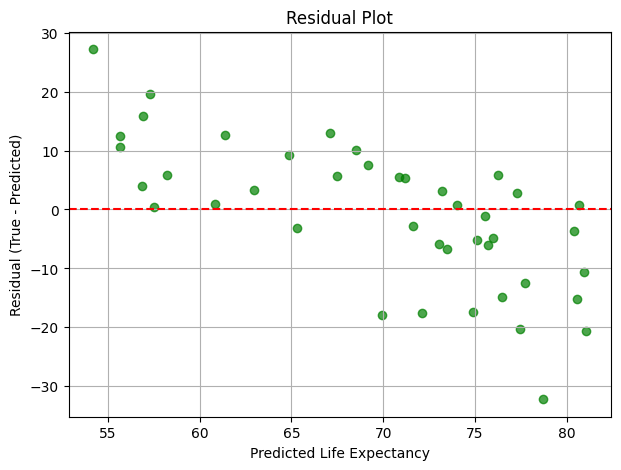

In [110]:
residuals = y_test - preds
plt.figure(figsize=(7,5))
plt.scatter(preds, residuals, alpha=0.7, color='green')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Life Expectancy")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [111]:
#Few larger negative residuals

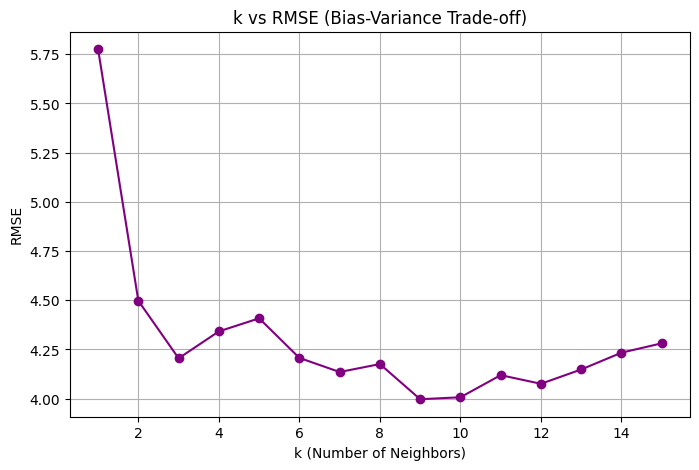

In [112]:
def knn_predict(x, X_train, y_train, k=3):
    dists = np.sqrt(np.sum((X_train - x)**2, axis=1))
    idx = np.argsort(dists)[:k]
    return np.mean(y_train[idx])

preds = np.array([knn_predict(x, X_train_s, y_train, k=3) for x in X_test_s])
ks = range(1, 16)
rmses = []
for k in ks:
    preds_k = np.array([knn_predict(x, X_train_s, y_train, k=k) for x in X_test_s])
    rmses.append(np.sqrt(np.mean((y_test - preds_k)**2)))

plt.figure(figsize=(8,5))
plt.plot(ks, rmses, marker='o', color='purple')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("RMSE")
plt.title("k vs RMSE (Bias-Variance Trade-off)")
plt.grid(True)
plt.show()

In [113]:
#k=3  slightly higher error but lower risk of overfitting

In [114]:
def knn_classification(X_train, y_train, X_test, k=3):
    preds = []
    for x in X_test:
        dists = euclidean_distances(X_train, x)
        idx = np.argsort(dists)[:k]
        vote = Counter(y_train[idx]).most_common(1)[0][0]
        preds.append(vote)
    return np.array(preds)

In [115]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)
y_reg = data["life_expec"].values
y_class = (y_reg >= np.median(y_reg)).astype(int)

In [116]:
from collections import Counter

In [117]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class)
scaler_c = StandardScaler()
X_train_c_s = scaler_c.fit_transform(X_train_c)
X_test_c_s = scaler_c.transform(X_test_c)

class_preds = knn_classification(X_train_c_s, y_train_c, X_test_c_s, k=3) 

print("\n KNN CLASSIFICATION")
print(f"Accuracy : {accuracy(y_test_c, class_preds):.4f}")


 KNN CLASSIFICATION
Accuracy : 0.8571


In [118]:
for k in [3,5,7,9,11,13]:
    preds = knn_classification(X_train_c_s, y_train_c, X_test_c_s, k=k)
    print(f"k={k} Accuracy: {accuracy(y_test_c, preds):.4f}")

k=3 Accuracy: 0.8571
k=5 Accuracy: 0.8571
k=7 Accuracy: 0.8571
k=9 Accuracy: 0.9048
k=11 Accuracy: 0.9048
k=13 Accuracy: 0.9286


In [119]:
# Classification with optimal k
class_preds = knn_classification(X_train_c_s, y_train_c, X_test_c_s, k=13)

print("=== KNN CLASSIFICATION (OPTIMIZED) ===")
print("k = 13")
print(f"Accuracy : {accuracy(y_test_c, class_preds):.4f}")

=== KNN CLASSIFICATION (OPTIMIZED) ===
k = 13
Accuracy : 0.9286


# k means

In [120]:
def pairwise_squared_distances(A, B):
    return ((A[:, None, :] - B[None, :, :]) ** 2).sum(axis=2)

def kmeans_pp_init(X, k, seed=42):
    rng = np.random.RandomState(seed)
    centers = [X[rng.randint(len(X))]]
    for _ in range(1, k):
        d2 = np.min(pairwise_squared_distances(X, np.array(centers)), axis=1)
        probs = d2 / d2.sum()
        centers.append(X[np.searchsorted(np.cumsum(probs), rng.rand())])
    return np.array(centers)

def kmeans(X, k, max_iter=300, tol=1e-4, seed=42):
    centers = kmeans_pp_init(X, k, seed)
    for _ in range(max_iter):
        d2 = pairwise_squared_distances(X, centers)
        labels = np.argmin(d2, axis=1)
        new_centers = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i] for i in range(k)])
        if np.linalg.norm(centers - new_centers) < tol:
            break
        centers = new_centers
    inertia = np.sum(np.min(pairwise_squared_distances(X, centers), axis=1))
    return centers, labels, inertia

In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.values)

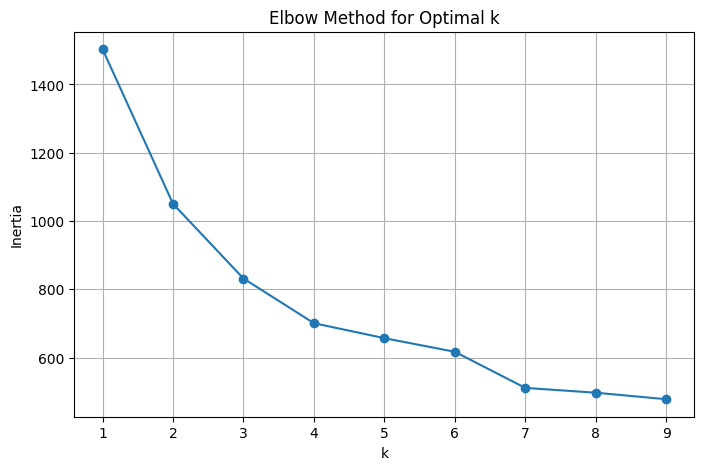

In [122]:
inertias = []
for k in range(1, 10):
    _, _, inertia = kmeans(X_scaled, k)
    inertias.append(inertia)

plt.figure(figsize=(8,5))
plt.plot(range(1,10), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [123]:
centers_scaled, labels, _ = kmeans(X_scaled, k=3)
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=data.columns)
centers_df.index.name = "cluster"
print(centers_df.round(2))

         child_mort  exports  health  imports    income  inflation  \
cluster                                                              
0              5.00    58.74    8.81    51.49  45672.22       2.67   
1             95.11    28.60    6.30    42.31   3539.84      11.99   
2             22.46    40.27    6.25    47.36  12321.74       7.72   

         life_expec  total_fer      gdpp  
cluster                                   
0             80.13       1.75  42494.44  
1             59.06       5.07   1766.71  
2             72.57       2.34   6461.77  


In [125]:
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {0: 36, 1: 45, 2: 86}


###### Cluster 0 (Developed): Wealthy nations Low child mortality, high health spending, high income/GDP, long life expectancy, low fertility.
###### Cluster 1 (Underdeveloped): Least developed nations Extremely high child mortality, high fertility, very low income/GDP, short life expectancy, high inflation.
######  Cluster 2 (Developing): Transitioning economies Moderate values across all indicators — improving but not yet developed.
